In [55]:
import fiona
import numpy as np
import pandas as pd
import geopandas as gpd
from dbfread import DBF
import matplotlib.pyplot as plt
import re
from pprint import pprint
from shapely.geometry import shape, Point, Polygon, MultiPolygon

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

from sklearn.model_selection import train_test_split

%matplotlib inline

# Load and clean data

In [24]:
df = pd.DataFrame(columns=["centroid","lat","lon","income","trees","reports","damage"])

**Sidewalks**

In [27]:
sidewalks = gpd.read_file('Sidewalk_Inventory/Sidewalk_Inventory.shp')
sidewalks.set_index("SWK_ID", inplace=True)
sidewalks = sidewalks[sidewalks.geometry.isna() == False] # remove nans

sidewalks_damages = gpd.read_file('Sidewalks_/Sidewalks_.shp') # contains updated damage scores
sidewalks_damages.set_index("SWK_ID", inplace=True)
sidewalks_damages = sidewalks_damages[~sidewalks_damages.index.duplicated(keep='first')] # remove duplicate indices

# sidewalks['damage'] = sidewalks_damages.New_SCI

df.centroid = sidewalks.geometry.centroid
df.lon = df.centroid.map(lambda x: x.x)
df.lat = df.centroid.map(lambda x: x.y) # automatically sets index of df to SWK_ID

df.damage = sidewalks_damages.New_SCI

**Income**

In [28]:
income_regions = gpd.read_file('Boston_Neighborhoods/Boston_Neighborhoods.shp')
incomes = {1:68209, 2:76968, 3:32103, 4:38235, 5:64514, 6:64514, 7:64514, 8:89916, 9:26883, 
           10:76101, 11:99029, 12:52733, 13:92771, 14:93257, 15:93298, 16:64514, 17:35201, 18:56429, 
           19:81220, 20:67408, 21:44709, 22:47937, 23:120359, 24:86025, 25:42792, 26:0 }

def which_neighborhood_income(cent):
    for i, region in income_regions.iterrows():
        shp = shape(region['geometry'])
        if cent.within(shp):
            return incomes[region.OBJECTID]

df.income = df.centroid.apply(which_neighborhood_income)

**Reports**

In [ ]:
reports = pd.read_csv('Sidewalk_Repair_311_Cases.csv')
prog = re.compile("(?<=\/)20[0-9][0-9]")
def extract_date(s):
    d = prog.search(s)
    return d.group(0)
reports['year'] = reports.open_dt.map(extract_date)

# abandon for now, taking too long

**Trees**

In [ ]:
# abandon for now

# Train

In [29]:
df.head()

,centroid,lat,lon,income,trees,reports,damage
SWK_ID,,,,,,,
1,POINT (-71.06990989825789 42.38122085141686),42.381221,-71.069910,92771.0,NaN,NaN,85.0
2,POINT (-71.06964788684151 42.38059604674949),42.380596,-71.069648,92771.0,NaN,NaN,47.0
3,POINT (-71.06968514333657 42.38068558482508),42.380686,-71.069685,92771.0,NaN,NaN,64.0
4,POINT (-71.06868507296026 42.38179081797815),42.381791,-71.068685,92771.0,NaN,NaN,56.0
5,POINT (-71.07020034726331 42.38110320519791),42.381103,-71.070200,92771.0,NaN,NaN,87.0


In [115]:
# normalize data
df = df[df.income.isna()==False]
df = df[df.damage.isna()==False]
df_norm = (df[['lat','lon','income','damage']] - df[['lat','lon','income','damage']].mean()) / (df[['lat','lon','income','damage']].max() - df[['lat','lon','income','damage']].min())

In [116]:
df_norm.describe()

,lat,lon,income,damage
count,2.316800e+04,2.316800e+04,2.316800e+04,2.316800e+04
mean,2.559122e-12,1.930515e-12,1.840149e-17,1.778810e-17
std,2.195340e-01,2.086977e-01,2.192332e-01,2.966664e-01
min,-5.307569e-01,-4.719383e-01,-3.719696e-01,-6.537785e-01
25%,-1.867833e-01,-1.654973e-01,-1.467353e-01,-2.037785e-01
50%,2.746877e-03,4.750414e-02,3.060431e-02,6.622151e-02
75%,1.816135e-01,1.601310e-01,1.638364e-01,2.562215e-01
max,4.692431e-01,5.280617e-01,6.280304e-01,3.462215e-01


In [117]:
train, test = train_test_split(df_norm, test_size=0.2)

In [130]:
model = Sequential()
model.add(Dense(10, input_dim=3))
model.add(Dense(10))
model.add(Dense(10))
model.add(Dense(1))

sgd = SGD(lr=0.001, clipnorm=1.)

model.compile(optimizer=sgd,
              loss='msle')

In [144]:
history = model.fit(train[['lat','lon','income']], train.damage, epochs=20, batch_size=32)

Epoch 1/20
18534/18534 [==============================] - 2s 81us/step - loss: 0.0134
Epoch 2/20
18534/18534 [==============================] - 1s 78us/step - loss: 0.0134
Epoch 3/20
18534/18534 [==============================] - 2s 85us/step - loss: 0.0134
Epoch 4/20
18534/18534 [==============================] - 1s 76us/step - loss: 0.0134
Epoch 5/20
18534/18534 [==============================] - 2s 82us/step - loss: 0.0134
Epoch 6/20
18534/18534 [==============================] - 1s 76us/step - loss: 0.0134
Epoch 7/20
18534/18534 [==============================] - 1s 72us/step - loss: 0.0134
Epoch 8/20
18534/18534 [==============================] - 1s 72us/step - loss: 0.0134
Epoch 9/20
18534/18534 [==============================] - 1s 73us/step - loss: 0.0134
Epoch 10/20
18534/18534 [==============================] - 2s 92us/step - loss: 0.0134
Epoch 11/20
18534/18534 [==============================] - 2s 103us/step - loss: 0.0134 1s - loss: 0.01 - ETA: 0s 
Epoch 12/20
18534/18534 

In [145]:
score = model.evaluate(test[['lat','lon','income']], test.damage, batch_size=128)

4634/4634 [==============================] - 0s 13us/step


In [146]:
score

0.013495234106126715

In [147]:
history.history.keys()

['loss']

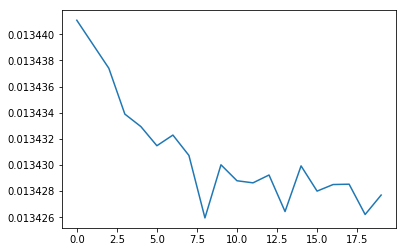

In [148]:
plt.plot(history.history['loss'])